In [90]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, RobustScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.target import FeatureCorrelation

In [2]:
df = pd.read_csv('../../../data/kc_house_data.csv')

### Joel's mrmodel

In [3]:
#this code is heavily borrowed from Joel Collins' solution for the Kaggle exercise
#input for model is previously calculated X_train, etc. data AND list of features from X_train
#to use the model, only change the features & rely on former X_train, etc.
def mrmodel(X_train, X_test, y_train, y_test, features):
    # Isolate the features for the model
    model_train = X_train[features]
    model_test = X_test[features]
    
    # Initialize a model
    model = LinearRegression()
    
    # Fit the model
    model.fit(model_train, y_train)
    
    # Generate training and test predictions
    train_preds = model.predict(model_train)
    test_preds = model.predict(model_test)
    
    # Calculate training and test error
    train_error = mean_squared_error(y_train, train_preds, squared=False)
    test_error = mean_squared_error(y_test, test_preds, squared=False)
    
    # return results
    difference = test_error - train_error
    print('train error', train_error)
    print('test error', test_error)
    print(f'difference: {difference}')

    r_sq = model.score(model_train, y_train)
    print('coefficient of determination:', r_sq)
    print('intercept:', model.intercept_)
    #intercept: 5.633333333333329
    model_info = pd.DataFrame([('intercept', model.intercept_)] + list(zip(model_train.columns, model.coef_)), columns=['feature', 'weight'])
    
    print(model_info)
    return model, model_train, model_test #note: this produces an array of outputs that need to be indexed

### residualizer

In [87]:
def residualizer(model, model_train, model_test, y_train, y_test):
    # this requires the yellowbrick api, which is called by...
    # from yellowbrick.regressor import ResidualsPlot
    # Instantiate the visualizer
    visualizer = ResidualsPlot(model, hist = False, qqplot=True)
    visualizer.fit(model_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(model_test, y_test)  # Evaluate the model on the test data
    return visualizer.show()                 # Finalize and render the figure

### plot bins

In [5]:
def plot_bins(model, X, y, bins=10, title='binned error'):
    q=pd.qcut(y, bins) #magical pandas function, makes quantiles (10 in this case)
    frame=pd.DataFrame(q) #takes cuts into a df so you can do groupby later
    frame['error']=model.predict(X)-y #estimates error
    frame.columns = ['bins', 'errors'] #reset column names
    avg=frame.groupby('bins').mean()
    avg['std']=frame.groupby('bins').std().iloc[:,0]
    avg.rename(columns={'bins':'mean'}, inplace=True)
    avg.plot(kind='bar', figsize=(15,6), title=title)

### sale_reg - combines all 3 functions

In [6]:
#needs input of features, model name, and X_train, X_test, etc
def sale_reg(X_train, X_test, y_train, y_test, features):
    mrmodel_outputs = mrmodel(X_train, X_test, y_train, y_test, features) #saves the 3 outputs of mrmodel
    residualizer(mrmodel_outputs[0], mrmodel_outputs[1], mrmodel_outputs[2], y_train, y_test)
    plot_bins(mrmodel_outputs[0], mrmodel_outputs[2], y_test)

### Model 1: example call of sale_reg

train error 262419.7884333472
test error 259878.49234916252
difference: -2541.2960841846652
coefficient of determination: 0.4886786453279144
intercept: -47377.18949402089
       feature        weight
0    intercept -47377.189494
1  sqft_living    281.862853


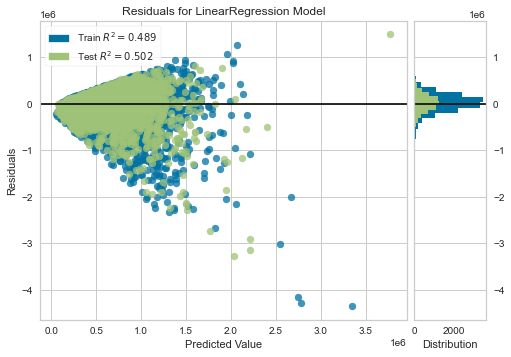

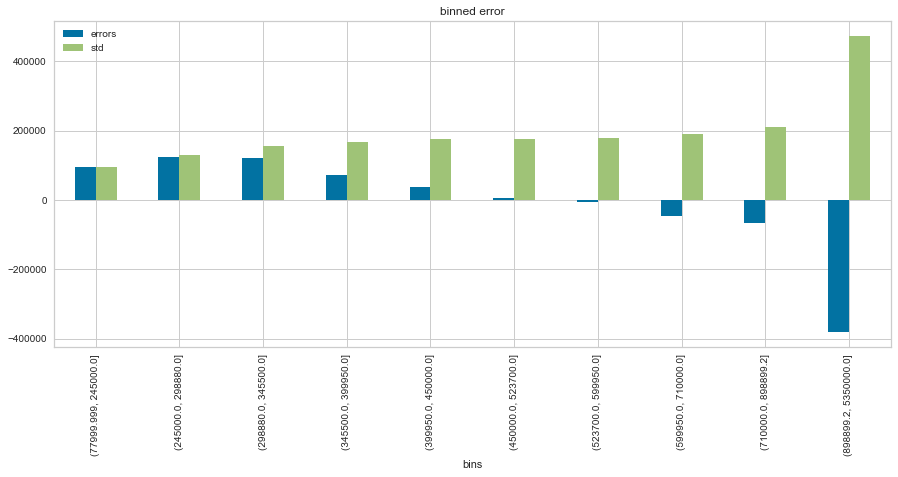

In [7]:
#set X & y variables
X = df.drop(['price'], axis = 1)
y = df['price']

#establish the features list
model_features = ['sqft_living']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2021)

#call the function (rename the output file every time)
model_1_results = sale_reg(X_train, X_test, y_train, y_test, model_features)
model_1_results

### modify data for models by calculating basement area

In [8]:
df_2 = df.copy()

In [9]:
# modify basement area to be = to total living area - above living area
df_2['sqft_basement'] = df_2['sqft_basement'].str.replace('?', '0')
df_2[['sqft_basement']] = df_2[['sqft_basement']].apply(pd.to_numeric)
df_2['area_basement'] = df_2['sqft_living']-df_2['sqft_above']

### model 2: all numerical features

In [10]:
'''This version of the model includes 12 features that we thought would most likely be important for house prices. 
This includes using zipcode as a numeric (changed in later models).'''

'This version of the model includes 12 features that we thought would most likely be important for house prices. \nThis includes using zipcode as a numeric (changed in later models).'

train error 226809.3163724381
test error 225347.17138654357
difference: -1462.144985894527
coefficient of determination: 0.6180358986328702
intercept: -3908662.141204477
          feature        weight
0       intercept -3.908662e+06
1        bedrooms -5.535659e+04
2       bathrooms  5.299249e+04
3     sqft_living  1.236013e+02
4        sqft_lot -3.758423e-03
5          floors  3.318063e+04
6       condition  1.906736e+04
7           grade  1.251580e+05
8      sqft_above  4.798106e+01
9        yr_built -3.918297e+03
10        zipcode  1.096098e+02
11  sqft_living15  3.206107e+01
12     sqft_lot15 -5.386288e-01
13  area_basement  7.562026e+01


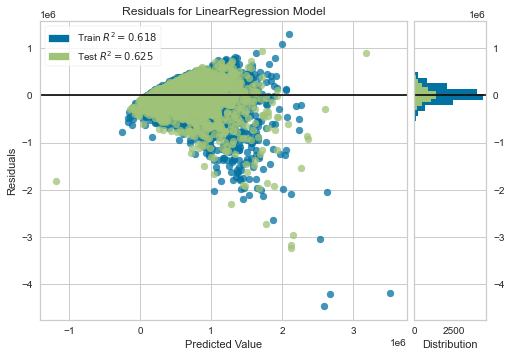

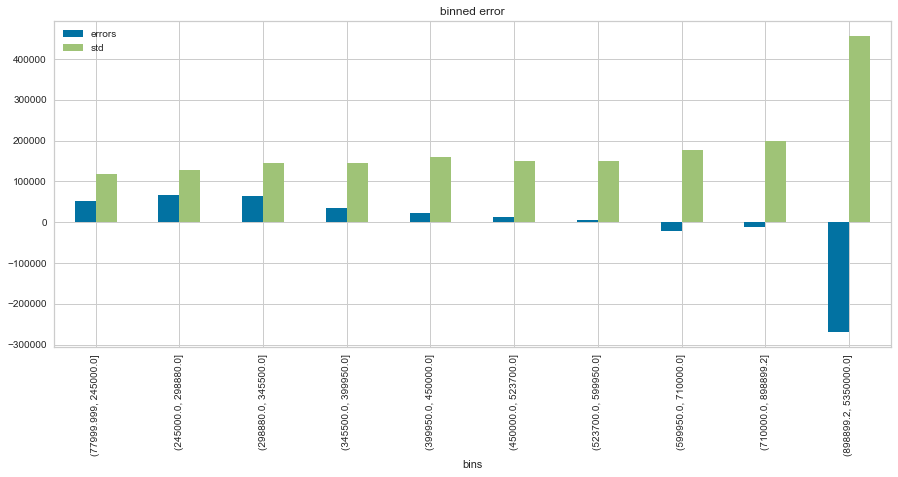

In [11]:
#set X & y variables
X = df_2.drop(['price'], axis = 1)
y = df_2['price']

#establish the features list
model_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'yr_built', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'area_basement']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2021)

#call the function (rename the output file every time)
model_2_results = sale_reg(X_train, X_test, y_train, y_test, model_features)
model_2_results

### Model 3: scaled predictors from model 2

In [12]:
#set predictors by dropping these variables
X_train_pared = X_train.drop(['id', 'date', 'waterfront', 'view', 'sqft_basement', 'lat', 'long', 'yr_renovated'], axis = 1)
X_test_pared = X_test.drop(['id', 'date', 'waterfront', 'view', 'sqft_basement', 'lat', 'long', 'yr_renovated'], axis = 1)

In [13]:
#scale training data
scaler = RobustScaler() #there are other options
scaler.fit(X_train_pared) #do this in first step w/ only train data
X_train = scaler.transform(X_train_pared) 

In [14]:
# Scale the test set, with same scalar
X_test = scaler.transform(X_test_pared)

In [15]:
X_train = pd.DataFrame(X_train, columns=X_train_pared.columns) #needed for scaled data to make it accessible to the function
X_test = pd.DataFrame(X_test, columns=X_test_pared.columns)

In [16]:
model_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'yr_built', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'area_basement']

train error 226809.31637243807
test error 225347.17138654666
difference: -1462.144985891413
coefficient of determination: 0.6180358986328702
intercept: 394573.7861123688
          feature         weight
0       intercept  394573.786112
1        bedrooms  -55356.591804
2       bathrooms   39744.370407
3     sqft_living  103992.962378
4        sqft_lot     -21.084755
5          floors   33180.625389
6       condition   19067.363753
7           grade  125157.986456
8      sqft_above   80306.146732
9        yr_built -172405.050456
10        zipcode    9207.225669
11  sqft_living15   28213.738820
12     sqft_lot15   -2658.133008
13  area_basement   60631.312625


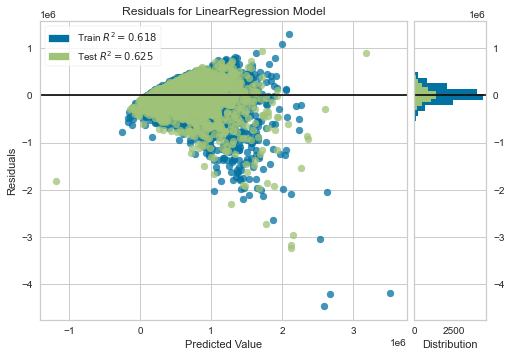

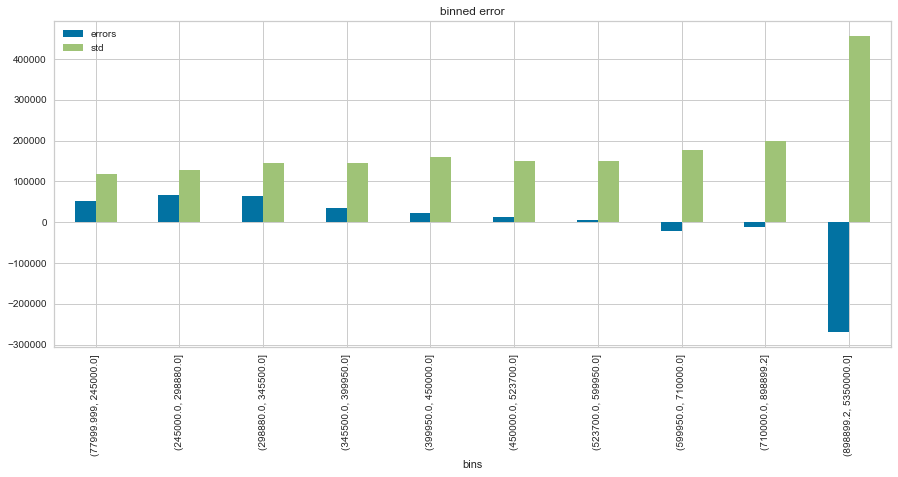

In [17]:
#call the function (rename the output file every time)
model_3_results = sale_reg(X_train, X_test, y_train, y_test, model_features)
model_3_results

### Model 4: re-run model 3 (scaled), but with log price as target

In [18]:
df_3 = df_2.copy()
df_3.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,area_basement
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,400
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,910
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,0


In [19]:
df_3['log_price'] = np.log(df_3['price'])

In [20]:
#set X & y variables
X = df_3.drop(['price', 'log_price'], axis = 1)
y = df_3['log_price']

In [21]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2021)

In [22]:
model_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'yr_built', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'area_basement']

train error 0.31121938746476135
test error 0.315555653695869
difference: 0.004336266231107666
coefficient of determination: 0.6484449290050489
intercept: -22.72003643231573
          feature        weight
0       intercept -2.272004e+01
1        bedrooms -3.201299e-02
2       bathrooms  8.199559e-02
3     sqft_living  1.060594e-04
4        sqft_lot  1.971076e-07
5          floors  1.228671e-01
6       condition  4.559304e-02
7           grade  2.121982e-01
8      sqft_above  3.728417e-06
9        yr_built -5.521141e-03
10        zipcode  4.499261e-04
11  sqft_living15  1.189385e-04
12     sqft_lot15 -3.774963e-07
13  area_basement  1.023310e-04


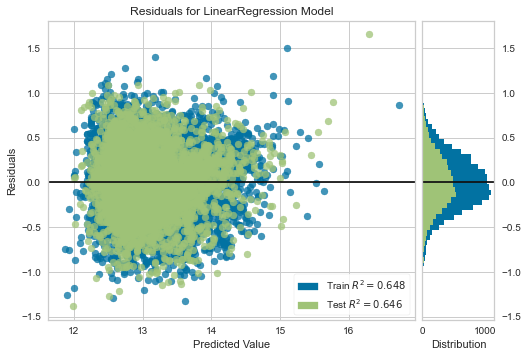

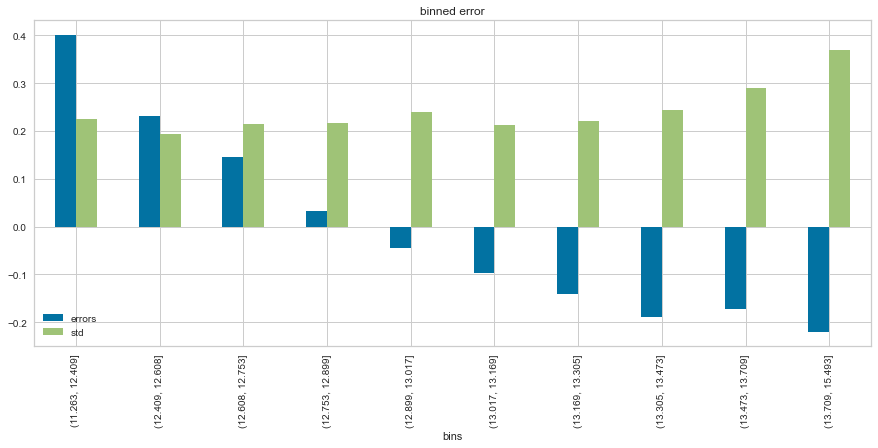

In [23]:
#call the function (rename the output file every time)
model_4_results = sale_reg(X_train, X_test, y_train, y_test, model_features)
model_4_results

### model5: simplified model 2 w/ fewer features

train error 227518.65418879347
test error 226215.79849525375
difference: -1302.855693539721
coefficient of determination: 0.6156430052027546
intercept: -3600607.543274485
       feature        weight
0    intercept -3.600608e+06
1     bedrooms -5.505154e+04
2    bathrooms  5.550395e+04
3  sqft_living  1.907550e+02
4     sqft_lot -2.561308e-01
5       floors  2.222916e+04
6    condition  1.946120e+04
7        grade  1.298941e+05
8     yr_built -3.956716e+03
9      zipcode  1.072529e+02


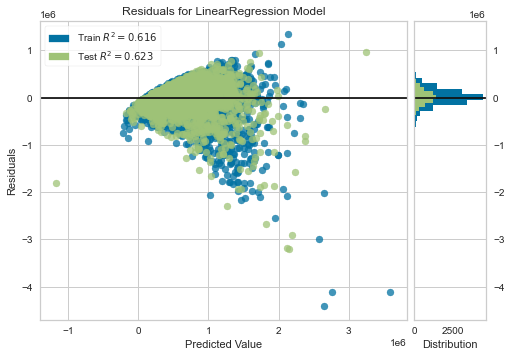

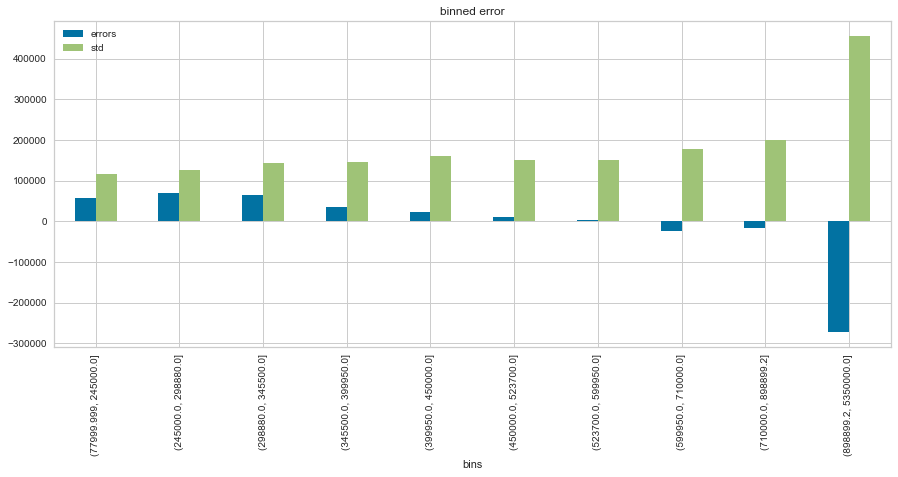

In [24]:
#set X & y variables
X = df_2.drop(['price'], axis = 1)
y = df_2['price']

#establish the features list
model_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'yr_built', 'zipcode']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2021)

#call the function (rename the output file every time)
model_2_results = sale_reg(X_train, X_test, y_train, y_test, model_features)
model_2_results

#### this simpler model results in poorer performance

### Model6: adding new interaction features that Emma identified among all possible 2-way combinations

In [30]:
#new df to work with given new features
df_3 = df_2.copy()

In [31]:
df_3['living*bath'] = df_3['sqft_living']*df_3['bathrooms']
df_3['living*grade'] = df_3['sqft_living']*df_3['grade']
df_3['grade*bath'] = df_3['grade']*df_3['bathrooms']
df_3.view = df_3.view.replace(np.nan, 0)
df_3.waterfront = df_3.waterfront.replace(np.nan, 0)
#df_3.head()

In [32]:
#set X & y variables
X = df_3.drop(['price'], axis = 1)
y = df_3['price']

In [33]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2021)

train error 187242.47643603454
test error 188290.74265648978
difference: 1048.2662204552325
coefficient of determination: 0.7396788095674223
intercept: 8900706.742211593
          feature        weight
0       intercept  8.900707e+06
1        bedrooms -1.212653e+04
2       bathrooms -7.158496e+03
3     sqft_living -1.613017e+02
4        sqft_lot  4.212476e-02
5          floors  4.305385e+04
6       condition  3.462466e+04
7           grade  1.768478e+04
8      sqft_above -8.927252e+01
9        yr_built -2.276464e+03
10        zipcode -5.562567e+02
11  sqft_living15  3.663995e+01
12     sqft_lot15 -3.275387e-01
13  area_basement -7.202915e+01
14     grade*bath -1.905096e+02
15   living*grade  3.630921e+01
16    living*bath  2.587920e+01
17            lat  5.962597e+05
18     waterfront  5.711090e+05
19           long -1.780575e+05
20           view  4.819872e+04


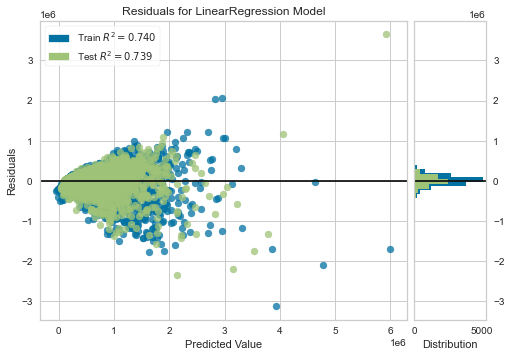

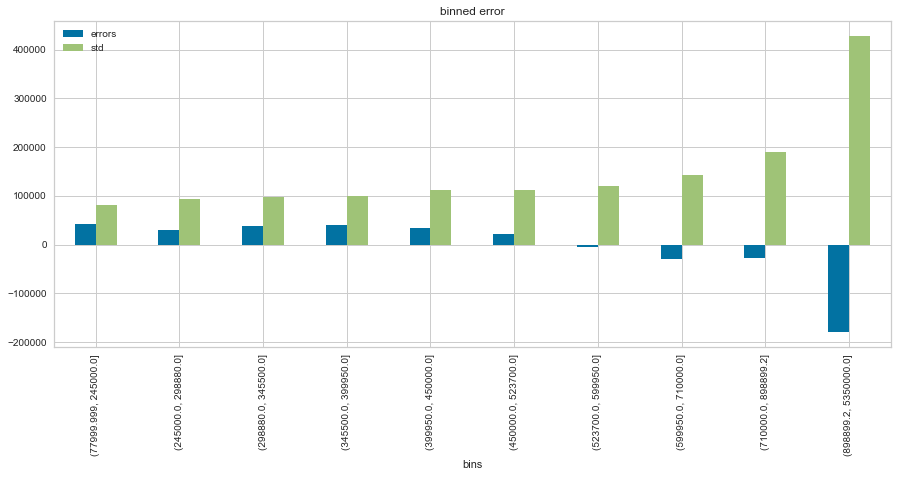

In [34]:
model_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'yr_built', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'area_basement', 'grade*bath', 
        'living*grade', 'living*bath', 'lat', 'waterfront', 'long', 'view']

model_6_results = sale_reg(X_train, X_test, y_train, y_test, model_features)
model_6_results

### Model 7: polynomial model

In [35]:
#make a new df to work with out of habit
df_4 = df_3.copy()
df_4 = df_4.drop(['id', 'date', 'yr_renovated'], axis=1)

#set X & y variables
X = df_4.drop(['price'], axis = 1)
y = df_4['price']

In [36]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2021)

In [37]:
# this process has to be a bit different - doesn't use sale_reg function, since it's a linear regr'n

# Instantiate PolynomialFeatures
poly = PolynomialFeatures(2)
# Fit and transform X_train
X_poly_fit = poly.fit(X_train)
X_poly_train = poly.transform(X_train)
    
# Instantiate and fit a linear regression model to the polynomial transformed train features
reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
# Transform the test data into polynomial features
X_poly_test = poly.transform(X_test)
    
# Get predicted values for transformed polynomial test data  
y_pred = reg_poly.predict(X_poly_test)
    
# Evaluate model performance on test data
r_sq = r2_score(y_test, y_pred)
    
# Transform the full data
X_poly = poly.transform(X)
    
# Now, we want to see what the model predicts for the entire data  
y_poly = reg_poly.predict(X_poly)

In [38]:
#interpret the error & fit of the model
train_preds = reg_poly.predict(X_poly_train)
test_preds = reg_poly.predict(X_poly_test)

train_error = mean_squared_error(y_train, train_preds, squared=False)
test_error = mean_squared_error(y_test, test_preds, squared=False)
print('train error', train_error)
print('test error', test_error)
difference = test_error - train_error
print(f'difference: {difference}')

print('coefficient of determination:', r_sq)
print('intercept:', reg_poly.intercept_)
#intercept: 5.633333333333329
#print('slopes:', reg_poly.coef_)

train error 147269.19903609788
test error 165436.39187948158
difference: 18167.192843383702
coefficient of determination: 0.7981412622564863
intercept: 22729406692.754795


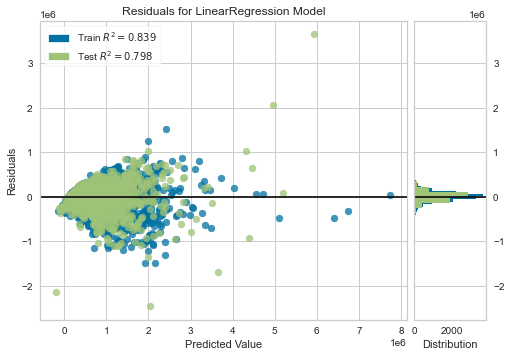

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [39]:
# Instantiate the visualizer
visualizer = ResidualsPlot(reg_poly)
visualizer.fit(X_poly_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_poly_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [52]:
# note: need help running the plot bins on this 

In [50]:
#Plot bins here
q=pd.qcut(y_train, 10) #magical pandas function, makes quantiles (10 in this case)
frame=pd.DataFrame(q) #takes cuts into a df so you can do groupby later
frame['error']=reg_poly.predict(X_test)-y_test #estimates error
frame.columns = ['bins', 'errors'] #reset column names
avg=frame.groupby('bins').mean()
avg['std']=frame.groupby('bins').std().iloc[:,0]
avg.rename(columns={'bins':'mean'}, inplace=True)
avg.plot(kind='bar', figsize=(15,6), title=title)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 253 is different from 21)

### Model 8: including OneHotEncoded zip codes saved as municipalities

In [58]:
path = '../../../data/King_co_zipcodes.csv'

zip_code_names = pd.read_csv(path)

In [59]:
#Merge spreadsheet with original DataFrame
df_merge = pd.merge(df_3, zip_code_names, on='zipcode')
df_merge

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,area_basement,living*bath,living*grade,grade*bath,municipality,population
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,47.5112,-122.257,1340,5650,0,1180.0,8260,7.00,Seattle,24092
1,4060000240,6/23/2014,205425.0,2,1.00,880,6780,1.0,0.0,0.0,...,47.5009,-122.248,1190,6780,0,880.0,5280,6.00,Seattle,24092
2,4058801670,7/17/2014,445000.0,3,2.25,2100,8201,1.0,0.0,2.0,...,47.5091,-122.244,2660,8712,480,4725.0,16800,18.00,Seattle,24092
3,2976800796,9/25/2014,236000.0,3,1.00,1300,5898,1.0,0.0,0.0,...,47.5053,-122.255,1320,7619,0,1300.0,9100,7.00,Seattle,24092
4,6874200960,2/27/2015,170000.0,2,1.00,860,5265,1.0,0.0,0.0,...,47.5048,-122.272,1650,8775,0,860.0,5160,6.00,Seattle,24092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2525049086,10/3/2014,2720000.0,4,3.25,3990,18115,2.0,0.0,0.0,...,47.6177,-122.229,3450,16087,0,12967.5,43890,35.75,Medina,2971
21593,2525049113,7/25/2014,1950000.0,4,3.50,4065,18713,2.0,0.0,0.0,...,47.6209,-122.237,3070,18713,0,14227.5,40650,35.00,Medina,2971
21594,3262300485,4/21/2015,2250000.0,5,5.25,3410,8118,2.0,0.0,0.0,...,47.6295,-122.236,3410,16236,0,17902.5,37510,57.75,Medina,2971
21595,6447300365,11/13/2014,2900000.0,5,4.00,5190,14600,2.0,0.0,1.0,...,47.6102,-122.225,3840,19250,0,20760.0,57090,44.00,Medina,2971


In [67]:
# OneHotEncoder and new dataframe df_ohe
ohe = OneHotEncoder(sparse=False)
df_ohe = pd.DataFrame(ohe.fit_transform(df_merge[['municipality']]), columns=ohe.get_feature_names(), index=df_3.index)

df_5 = pd.concat([df_3.drop('zipcode', axis=1), df_ohe], axis=1)

In [69]:
#new df to work with given new features
df_5 = df_5.drop(['id', 'date', 'yr_renovated'], axis=1)

In [70]:
#set X & y variables
X = df_5.drop(['price'], axis = 1)
y = df_5['price']

In [75]:
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'area_basement', 'living*bath', 'living*grade',
       'grade*bath', 'x0_Auburn', 'x0_Bellevue', 'x0_Black Diamond',
       'x0_Bothell', 'x0_Carnation', 'x0_Duvall', 'x0_Enumclaw',
       'x0_Fall City', 'x0_Federal Way', 'x0_Issaquah', 'x0_Kenmore',
       'x0_Kent', 'x0_Kirkland', 'x0_Maple Valley', 'x0_Medina',
       'x0_Mercer Island', 'x0_North Bend', 'x0_Redmond', 'x0_Renton',
       'x0_Sammamish', 'x0_Seattle', 'x0_Snoqualmie', 'x0_Vashon',
       'x0_Woodinville'],
      dtype='object')

In [71]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2021)

train error 188339.06526292983
test error 190695.72440435935
difference: 2356.6591414295253
coefficient of determination: 0.736620729685546
intercept: -32211412.77361748
             feature        weight
0          intercept -3.221141e+07
1           bedrooms -1.049563e+04
2          bathrooms  6.707231e+03
3        sqft_living -7.284691e+10
4           sqft_lot  3.744311e-02
5             floors  3.582105e+04
6         waterfront  5.756428e+05
7               view  4.533571e+04
8          condition  3.849443e+04
9              grade  2.142427e+04
10        sqft_above  7.284691e+10
11     sqft_basement  5.091263e+01
12          yr_built -2.176346e+03
13               lat  5.555331e+05
14              long -8.186030e+04
15     sqft_living15  4.175238e+01
16        sqft_lot15 -3.341991e-01
17     area_basement  7.284691e+10
18       living*bath  2.630015e+01
19      living*grade  3.712959e+01
20        grade*bath -1.978006e+03
21         x0_Auburn  2.342660e+03
22       x0_Bellevue  1.3

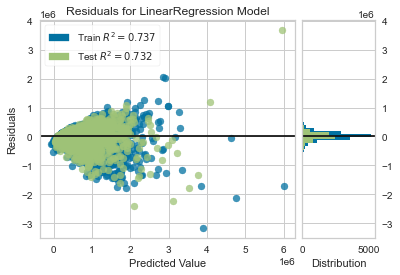

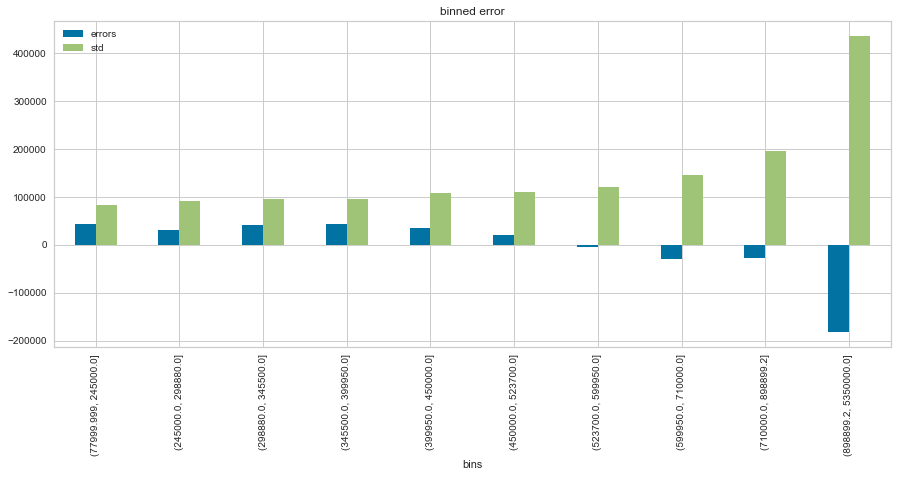

In [76]:
model_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'area_basement', 'living*bath', 'living*grade',
       'grade*bath', 'x0_Auburn', 'x0_Bellevue', 'x0_Black Diamond',
       'x0_Bothell', 'x0_Carnation', 'x0_Duvall', 'x0_Enumclaw',
       'x0_Fall City', 'x0_Federal Way', 'x0_Issaquah', 'x0_Kenmore',
       'x0_Kent', 'x0_Kirkland', 'x0_Maple Valley', 'x0_Medina',
       'x0_Mercer Island', 'x0_North Bend', 'x0_Redmond', 'x0_Renton',
       'x0_Sammamish', 'x0_Seattle', 'x0_Snoqualmie', 'x0_Vashon',
       'x0_Woodinville']

model_7_results = sale_reg(X_train, X_test, y_train, y_test, model_features)
model_7_results

### Model 9: iterative modeling to remove poor predictors and simplify model

In [77]:
#set X & y variables
# ~~~~~~~~~~~~based on model 6 & df_3~~~~~~~~~~~~~~~~

X = df_3.drop(['price'], axis = 1)
y = df_3['price']

In [78]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2021)

train error 191327.7709876513
test error 190102.54411773905
difference: -1225.226869912265
coefficient of determination: 0.7281954061370903
intercept: 11894905.304711606
        feature        weight
0     intercept  1.189491e+07
1      bedrooms -1.840963e+04
2     bathrooms -4.257554e+05
3   sqft_living  1.356097e+02
4        floors  3.001725e+04
5     condition  3.383722e+04
6         grade -3.348438e+04
7      yr_built -2.250767e+03
8       zipcode -6.038418e+02
9    grade*bath  6.078697e+04
10          lat  6.081349e+05
11   waterfront  5.855069e+05
12         long -1.891787e+05
13         view  5.223567e+04


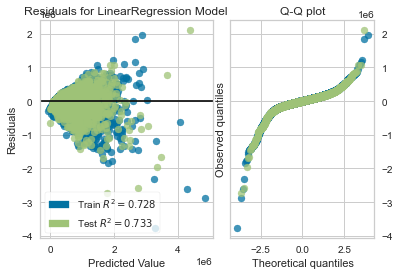

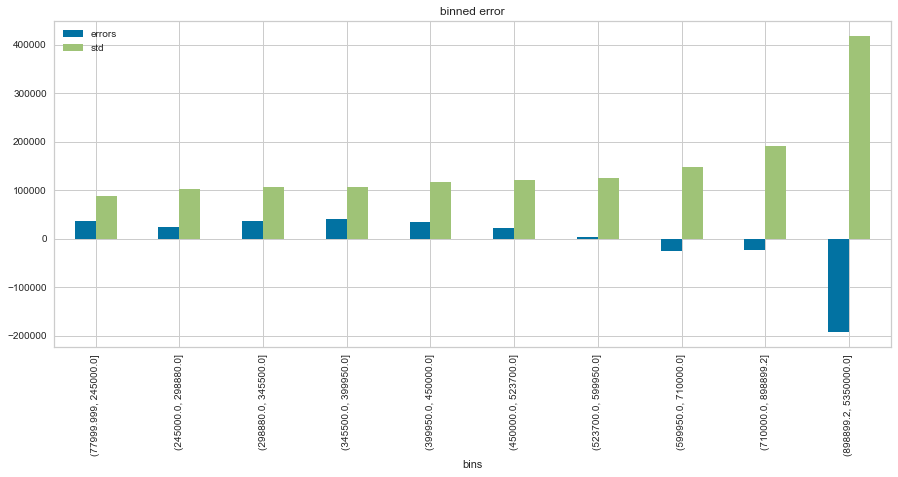

In [88]:
model_features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'condition', 'grade', 'yr_built', 'zipcode', 'grade*bath', 
         'lat', 'waterfront', 'long', 'view']
#remove 'living*grade', 'living*bath', 'sqft_lot15', 'sqft_living15', 'sqft_lot', 'area_basement', 'sqft_above', 
model_9_results = sale_reg(X_train, X_test, y_train, y_test, model_features)
model_9_results